In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pymsm.datasets import prep_covid_hosp_data
from pymsm.multi_state_competing_risks_model import MultiStateModel
from pymsm.plotting import stackplot_state_timesteps_from_paths
from pymsm.statistics import (
    prob_visited_states,
    stats_total_time_at_states,
    get_path_frequencies,
    path_total_time_at_states
)
from pymsm.simulation import MultiStateSimulator

pd.set_option("display.max_rows", 100)
%load_ext autoreload
%autoreload 2

# Load Covid hospitalization data set  
raw public data available at https://github.com/JonathanSomer/covid-19-multi-state-model/blob/master/data/data_for_paper.csv

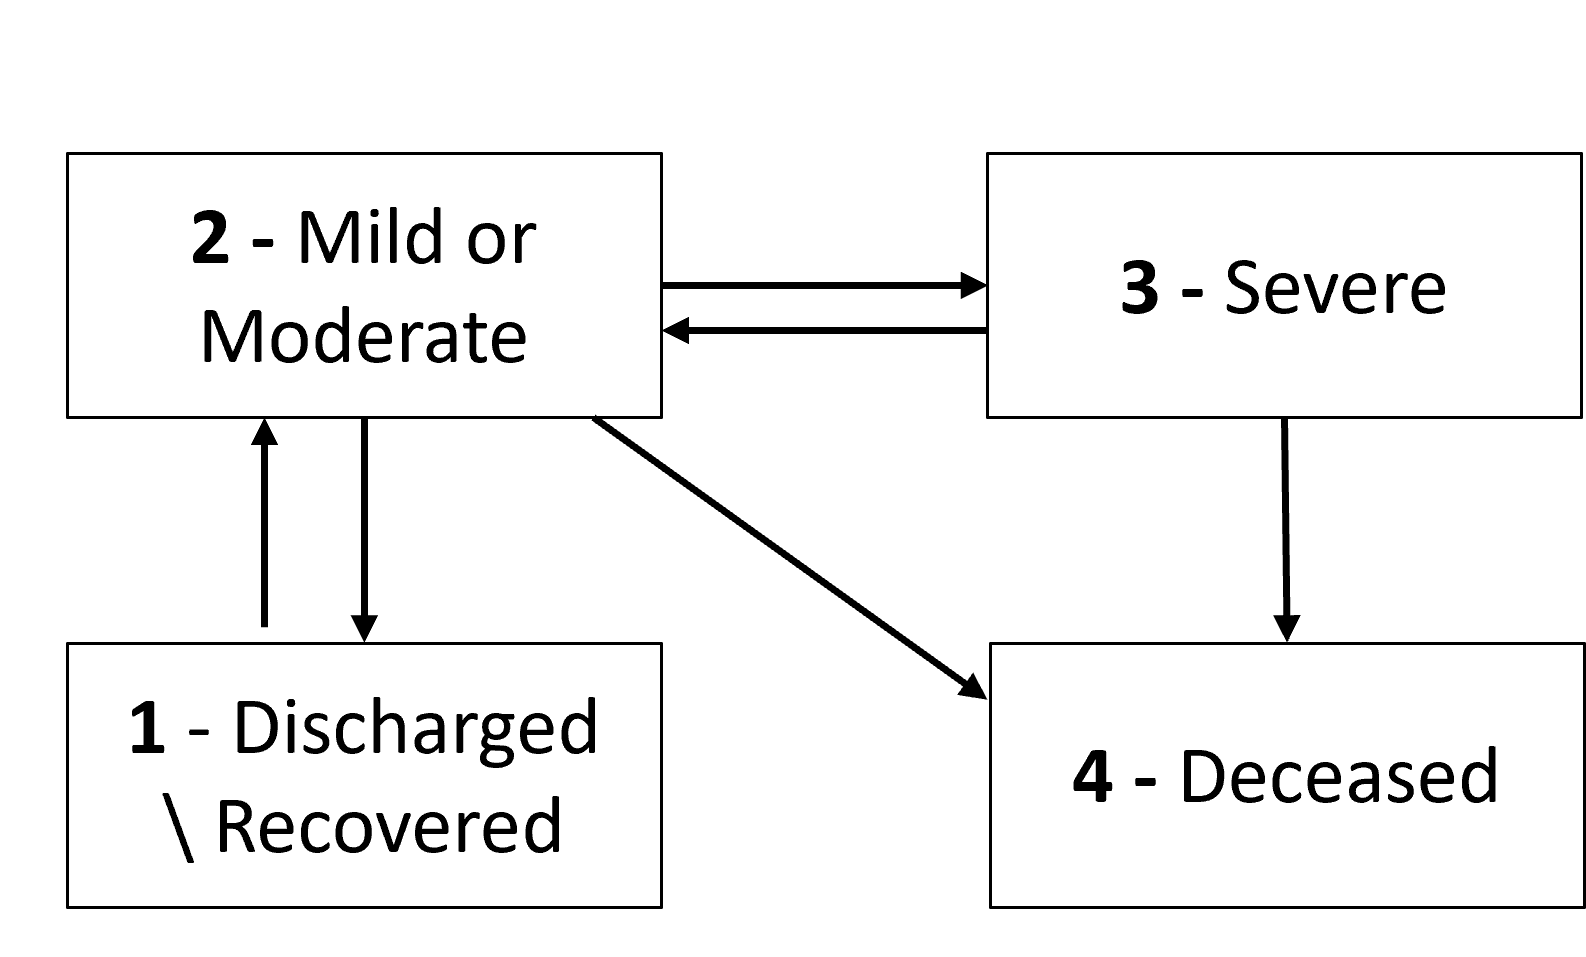

In [4]:
from IPython.display import Image
Image(filename="covid_states.png", width=600)

In [5]:
covid_dataset = prep_covid_hosp_data()

# Some path definitions
# covariate_cols = ["is_male", "age", "was_severe", "cum_hosp_time"]
covariate_cols = ["is_male", "age", "was_severe"]

states_labels_long = {
    0: "Censored",
    1: "Discharged\Recovered",
    2: "Mild or Moderate",
    3: "Severe",
    4: "Deceased",
}
states_labels = {0: "C", 1: "R", 2: "M", 3: "S", 4: "D"}
terminal_states = [4]


100%|██████████| 2675/2675 [00:08<00:00, 302.35it/s]


Let's look at one patients path

In [6]:
covid_dataset[567].print_path()

Sample id: 577
States: [2 3 4]
Transition times: [ 6 31]
Covariates:
is_male        1.0
age           72.5
was_severe     0.0
Name: 567, dtype: float64


Path frequencies for all different trajectories in the data

In [7]:
path_freqs = get_path_frequencies(covid_dataset, states_labels)
print(path_freqs)

M->R                               1906
M                                   202
M->S                                 76
S->D                                 74
M->S->D                              59
M->S->M->R                           46
M->D                                 44
M->R->M->R                           42
S                                    42
M->R->M                              36
M->S->M                              35
S->M->R                              28
S->M                                 27
M->S->M->S                            8
S->R                                  6
S->M->S                               5
S->M->S->M->R                         3
S->M->D                               3
M->S->M->S->M                         3
M->S->M->S->M->R                      3
M->R->M->R->M->R                      3
M->S->R                               3
S->M->S->D                            2
M->S->M->D                            2
M->R->M->S                            2


# Fitting the Multistate model

In [8]:
def covid_update_covariates_function(
    covariates_entering_origin_state,
    origin_state=None,
    target_state=None,
    time_at_origin=None,
    abs_time_entry_to_target_state=None,
):
    covariates = covariates_entering_origin_state.copy()

    # update is_severe covariate
    if origin_state == 3:
        covariates['was_severe'] = 1

    # # update cum_hosp_tim covariate
    # if ((origin_state==2) & (origin_state==3)):
    #     covariates["cum_hosp_time"] += time_at_origin

    return covariates


multi_state_model = MultiStateModel(
    covid_dataset, terminal_states, covid_update_covariates_function, covariate_cols,
)


multi_state_model.fit()


Fitting Model at State: 2
>>> Fitting Transition to State: 1, n events: 2135
>>> Fitting Transition to State: 3, n events: 275
>>> Fitting Transition to State: 4, n events: 52
Fitting Model at State: 1
>>> Fitting Transition to State: 2, n events: 98
>>> Fitting Transition to State: 3, n events: 2


/home/hagair/anaconda3/envs/pymsm/lib/python3.9/site-packages/lifelines/utils/__init__.py:1123: ConvergenceWarning: Column is_male have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['target_state'].astype(bool)
>>> print(df.loc[events, 'is_male'].var())
>>> print(df.loc[~events, 'is_male'].var())

A very low variance means that the column is_male completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/hagair/anaconda3/envs/pymsm/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.537. This may imply non-unique solutions to the maximum likelihood. Perha

Fitting Model at State: 3
>>> Fitting Transition to State: 2, n events: 193
>>> Fitting Transition to State: 1, n events: 9
>>> Fitting Transition to State: 4, n events: 135


/home/hagair/anaconda3/envs/pymsm/lib/python3.9/site-packages/lifelines/utils/__init__.py:1123: ConvergenceWarning: Column was_severe have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['target_state'].astype(bool)
>>> print(df.loc[events, 'was_severe'].var())
>>> print(df.loc[~events, 'was_severe'].var())

A very low variance means that the column was_severe completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/hagair/anaconda3/envs/pymsm/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.262. This may imply non-unique solutions to the maximum likel

# Single patient stats  
Let's take a look at how the model models transitions for a single patient - a female aged 75  
We'll run a Monte-Carlo simulation for 100 samples and present some path statistics

In [9]:
# Run MC for a sample single patient
mc_paths = multi_state_model.run_monte_carlo_simulation(
    sample_covariates=pd.Series({"is_male":0, "age":75, "was_severe":0}),
    origin_state=2,
    current_time=0,
    n_random_samples=100,
    max_transitions=10,
    print_paths=False,
    n_jobs=-1
)

100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Let's calculate the probability of being in any of the states and also obtain stats regarding time in each state

In [10]:
# Probability of visiting any of the states
for state, state_label in states_labels_long.items():
    if state == 0:
        continue
    print(
        f"Probabilty of ever being {state_label} = {prob_visited_states(mc_paths, states=[state])}"
    )


# Stats for times at states
dfs = []
for state, state_label in states_labels_long.items():
    if state == 0 or state in terminal_states:
        continue
    dfs.append(
        pd.DataFrame(
            data=stats_total_time_at_states(mc_paths, states=[state]),
            index=[state_label],
        )
    )
pd.concat(dfs).round(3).T


Probabilty of ever being Discharged\Recovered = 0.09
Probabilty of ever being Mild or Moderate = 1.0
Probabilty of ever being Severe = 0.36
Probabilty of ever being Deceased = 1.0


,Discharged\Recovered,Mild or Moderate,Severe
time_in_state_mean,4.170,3.650,1.390
time_in_state_std,14.965,2.095,3.283
time_in_state_median,0.000,3.000,0.000
time_in_state_min,0.000,1.000,0.000
time_in_state_max,72.000,12.000,24.000
time_in_state_quantile_0.1,0.000,1.000,0.000
time_in_state_quantile_0.25,0.000,2.000,0.000
time_in_state_quantile_0.75,0.000,5.000,1.000
time_in_state_quantile_0.9,0.000,6.000,5.000


Print out the path frequences for the sampled paths

In [11]:
path_freqs = get_path_frequencies(mc_paths, states_labels)
path_freqs.head(10)

M->D          56
M->S->D       34
M->R->M->D     8
M->R->S->D     1
M->S->M->D     1
dtype: int64

A CDF for the total time in hospital

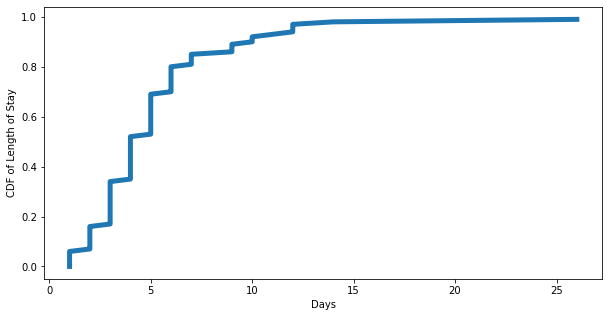

In [12]:
los = np.array([path_total_time_at_states(path, states = [2,3]) for path in mc_paths])

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(np.sort(los), np.linspace(0, 1, len(los), endpoint=False), lw=5)
# ax.set_xlim(0,20)
ax.set_ylabel('CDF of Length of Stay')
ax.set_xlabel('Days');

We can also look at Monte-Carlo simulations for the same patient, assuming we already know she has been in the Severe (3) state, for 2 days.

To do this, we simply need to set the *origin_state* to 3, set the *current_time* to 2, and update her covariates accordingly.

In [13]:
# Run MC for a sample single patient
mc_paths_severe = multi_state_model.run_monte_carlo_simulation(
    sample_covariates=pd.Series({"is_male":0, "age":75, "was_severe": 1}),
    origin_state=3,
    current_time=2,
    n_random_samples=100,
    max_transitions=10,
    print_paths=False,
    n_jobs=-1
)

100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


Now we can calculate the probability of being in any of the states and obtain stats regarding time in each state.

We can compare these to the statistics we obtained above, when the patient started in a Mild (2) state.

In [14]:
# Probability of visiting any of the states
for state, state_label in states_labels_long.items():
    if state == 0:
        continue
    print(
        f"Probabilty of ever being {state_label} = {prob_visited_states(mc_paths_severe, states=[state])}"
    )


# Stats for times at states
dfs = []
for state, state_label in states_labels_long.items():
    if state == 0 or state in terminal_states:
        continue
    dfs.append(
        pd.DataFrame(
            data=stats_total_time_at_states(mc_paths_severe, states=[state]),
            index=[state_label],
        )
    )
pd.concat(dfs).round(3).T

Probabilty of ever being Discharged\Recovered = 0.0
Probabilty of ever being Mild or Moderate = 0.06
Probabilty of ever being Severe = 1.0
Probabilty of ever being Deceased = 1.0


,Discharged\Recovered,Mild or Moderate,Severe
time_in_state_mean,0.0,0.100,6.190
time_in_state_std,0.0,0.539,6.418
time_in_state_median,0.0,0.000,4.000
time_in_state_min,0.0,0.000,0.000
time_in_state_max,0.0,4.000,25.000
time_in_state_quantile_0.1,0.0,0.000,0.000
time_in_state_quantile_0.25,0.0,0.000,1.000
time_in_state_quantile_0.75,0.0,0.000,11.000
time_in_state_quantile_0.9,0.0,0.000,15.000


# Saving the model and configuring a simulator  
We can save the model for later use, and configure a simulator to generate simulated paths

In [15]:
from pymsm.simulation import extract_competing_risks_models_list_from_msm

competing_risks_models_list = extract_competing_risks_models_list_from_msm(
    multi_state_model, verbose=True
)

# Configure the simulator
mssim = MultiStateSimulator(
    competing_risks_models_list,
    terminal_states=[5, 6],
    update_covariates_fn=covid_update_covariates_function,
    covariate_names=covariate_cols,
)


2 1 <pymsm.competing_risks_model.EventSpecificModel object at 0x7fd858c763a0>
2 3 <pymsm.competing_risks_model.EventSpecificModel object at 0x7fd858cbbd90>
2 4 <pymsm.competing_risks_model.EventSpecificModel object at 0x7fd858d261f0>
1 2 <pymsm.competing_risks_model.EventSpecificModel object at 0x7fd89711ad00>
1 3 <pymsm.competing_risks_model.EventSpecificModel object at 0x7fd858d1c730>
3 2 <pymsm.competing_risks_model.EventSpecificModel object at 0x7fd858cbb5b0>
3 1 <pymsm.competing_risks_model.EventSpecificModel object at 0x7fd851fa76a0>
3 4 <pymsm.competing_risks_model.EventSpecificModel object at 0x7fd851f32e20>


And now we can sample paths from this simulator  

In [16]:
# Run MC for a sample single patient
sim_paths = multi_state_model.run_monte_carlo_simulation(
    sample_covariates=pd.Series({"is_male":0, "age":75, "was_severe": 0}),
    origin_state=3,
    current_time=2,
    n_random_samples=100,
    max_transitions=10,
    print_paths=True,
    n_jobs=-1
)

100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


States: [3, 4]
Transition times: [4.60026420201487e-06]


States: [3, 4]
Transition times: [3.000002431596643]


States: [3, 4]
Transition times: [1.0000398504734398]


States: [3, 4]
Transition times: [2.4398964337812856e-05]


States: [3, 4]
Transition times: [2.000049379559637]


States: [3, 4]
Transition times: [3.0000161628714093]


States: [3, 4]
Transition times: [4.000045606998421]


States: [3, 4]
Transition times: [2.000094724857738]


States: [3, 4]
Transition times: [17.00009307573256]


States: [3, 4]
Transition times: [2.000049379559637]


States: [3, 4]
Transition times: [12.000005755876002]


States: [3, 4]
Transition times: [3.438852111514734e-06]


States: [3, 4]
Transition times: [1.000003734818875]


States: [3, 4]
Transition times: [1.0000649963930779]


States: [3, 4]
Transition times: [4.000072821634861]


States: [3, 4]
Transition times: [3.000052006802118]


States: [3, 4]
Transition times: [3.0000330898024856]


States: [3, 4]
Transition times: [2.807723624398